# Centrality and semi-supervised learning with graphs and hypergraphs

> Blocco con rientro



# Centrality 

In [ ]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import networkx as nx
import scipy.io as sio
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression

## Function preamble

### Power method

In [ ]:
def power_method(n,A, tol=1e-6,maxit=1000, norm='l2'):
    # Input:
    # n is the size of the matrix M which is part of the function Mf
    # A matrix
    # tol and maxit are the tolerance for stopping the iterations and the maximum number of iterations we can implement
    # Output: eigenvalue and eigenvector

    # Initialization
    count = 0
    error = 1
    x = np.random.rand(n)
    mu_new = 0
    if norm == 'l2':
      while count < maxit and error > tol:
        mu_old = mu_new
        y = A@x                         # y = A x
        x = y/np.linalg.norm(y)         # normalize 
        mu_new = x@A@x                  # mu = x^t A x
        error = abs(mu_new-mu_old)      # absolute value between two consecutive mu
        count = count+1                 # aggiornamento count
    if norm == 'l1':
        mu_old = mu_new
        y = A@x                         # y = A x
        x = y/sum(y)                    # normalize 
        mu_new = x@A@x                  # mu = x^t A x
        error = abs(mu_new-mu_old)      # absolute value between two consecutive mu
        count = count+1                 # aggiornamento count

    return mu_new, x
    

### Functions

In [ ]:
def load_Harvard_dataset():
  # Output: adjacency matrix, list of node names
  
  # load Adjacency matrix
  Adj = sio.mmread('Harvard500.mtx')  # sparse coordinate format
  Adj = csr_matrix(Adj)

  # load node names
  f = open('Harvard500_nodename.txt')
  names = []
  for riga in f.readlines():
    names.append(riga)
  f.close() 

  return Adj, names

In [ ]:
def largest_strongly_connected_component(Adj, tot_link):
  # Input: adjacency matrix, list of node names
  # Output: adj matrix of the largest strongly connected component, updated list of node names

  # adj matrix of the largest strongly connected component
  G = nx.from_numpy_matrix(Adj.toarray(),create_using=nx.DiGraph)  # graph 
  index = max(nx.strongly_connected_components(G), key=len)        # set of nodes in largest scc    
  index= list(index)                                               # tranform in list
  A = Adj[index,:][:,index]                                        # extract adj matrix of largest scc    

  # extract list of node names                       
  link = [tot_link[i] for i in index]                              
  
  return A, link

In [ ]:
def degree_centrality(A):
  # Compute in-degree and out-degree

  n = np.shape(A)[0]
  d_in = (np.ones(n))@A     # 1^t A
  d_out = A@(np.ones(n))    # A   1

  return d_in/sum(d_in), d_out/sum(d_out)

In [ ]:
def eigenvector_centrality(A):
  # Compute eigenvector in and eigenvector out

  n = np.shape(A)[0]                                                # A dimension

  # Compute eigenvalues and eigenspace
  eigval_in, eig_in = power_method(n, A, tol=1e-8, maxit=1000)      # Power method with A
  eigval_out, eig_out = power_method(n, A.T, tol=1e-8, maxit=1000)  # Power method with A^t
  
  return eig_in/sum(eig_in), eig_out/sum(eig_out)

In [ ]:
def hits_centrality(A):
  # Compute hubs and authorities

  n = np.shape(A)[0]                                         # A dimension

  # Create matrix M=[0   A
  #                  A^t 0]
  U = sp.sparse.hstack([np.zeros([n,n]),A])
  L = sp.sparse.hstack([A.T,np.zeros([n,n])])
  M = sp.sparse.vstack([U,L])
  
  # Compute eigenvalues and eigenspace of M
  eigval, eig = power_method(2*n,M, tol=1e-6,maxit=1000)

  hubs = eig[0:n]
  authorities = eig[n:]
  
  return hubs/sum(hubs), authorities/sum(authorities)

In [ ]:
def pagerank(A, random_jump_vector=(1/335)*np.ones(335),alfa=0.85):
  # Compute pagerank

  n = np.shape(A)[0]                                     # A dimension
  d_out = A@(np.ones(n))                                 # D = A 1
  invD = sp.sparse.diags(1/d_out)                        # D^(-1)
  Y = np.vstack([random_jump_vector]*n)                  # create matrix Y
  P = np.asarray(alfa*invD@A + (1-alfa)*Y)               # matrix P
  
  # we can find the solution in two ways
  # 1) using the power method on the matrix P^t and using the norm 1 instead the norm 2
  eigval, x1 = power_method(n,P.T, tol=1e-6,maxit=1000,norm='l1')  
  # 2) soving the linear system [1 - (alfa * A^t * D^-1)] x = (1-alfa)*(random jump)
  x2 = sp.sparse.linalg.spsolve(sp.sparse.diags(np.ones(n))-alfa*A.T@invD,(1-alfa)*random_jump_vector)
  return x2

In [ ]:
def compute_centrality(A,name="degree"):
  if name =="d_in":
    centrality, _ = degree_centrality(A)
  if name =="d_out":
    _, centrality = degree_centrality(A)
  if name == "pagerank":
    centrality = pagerank(A, random_jump_vector)
  if name == "hubs":
    centrality, _ = hits_centrality(A)
  if name == "authorities":
    _, centrality = hits_centrality(A)
  if name == "eig_in":
    centrality, _ = eigenvector_centrality(A)
  if name == "eig_out":
    _, centrality = eigenvector_centrality(A)
  return centrality

## Warm up with a small graph dataset
Download the Harvard network dataset from:   
https://suitesparse-collection-website.herokuapp.com/MM/MathWorks/Harvard500.tar.gz   
and load it into a directed adjacency matrix + a list (or dictionary) of node names

In [ ]:
Adj, tot_link = load_Harvard_dataset()

Extract the adjacency matrix of the subgraph corresponding to the largest connected component and the names (links) of nodes

In [ ]:
A,link = largest_strongly_connected_component(Adj,tot_link) 

### Q1. 
Compute the following centralities:    
- indegree, 
- outdegree, 
- eigenvector_in, 
- eigenvector_out, 
- hub, 
- authorities, 
- Pagerank (alpha = 0.85, uniform probability to random jump)  

using the power method for those that require eigenvector computations.
Normalize all centrality vectors so that the sum of their entries is one. 

In [ ]:
names = ["d_in", "d_out", "pagerank", "hubs", "authorities", "eig_in", "eig_out"]
random_jump_vector=(1/np.shape(A)[0])*np.ones(np.shape(A)[0])
centralities = dict();
for name in names:
    centralities[name] = compute_centrality(A,name=name)

### Q2. 
Print a table that shows the top 10 nodes for all these methods (list the names of the nodes) and produce a scatter plot comparing Pagerank with hubs and authorities. Scatter plots are standard plotting tools, which you can read about for example [here](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html)

In [ ]:
def top_nodes_table(centrality,link):
  # Input: centrality and labels
  # Output: top ten node names and index

  top_nodes = np.argsort(centrality)[::-1][:10]
  top_nodes_name = [link[i] for i in top_nodes]
  return top_nodes_name, top_nodes

Table that shows the top 10 nodes for all these methods

In [ ]:
# Create dict with name centralities and nodes (if you want to see node names is sufficient to eliminate comment)
table = dict()
for name in names:
  top_nodes_name, top_nodes_index = top_nodes_table(centralities[name],link)
  table[name] = top_nodes_index
  #table[name] = top_nodes_name

df = pd.DataFrame(table)
  
# displaying the DataFrame
pd.DataFrame(df)

,d_in,d_out,pagerank,hubs,authorities,eig_in,eig_out
0,38,0,4,0,186,0,16
1,37,15,38,182,189,16,177
2,15,171,15,177,178,182,189
3,170,170,37,188,179,180,188
4,12,165,6,187,180,179,186
5,6,206,0,186,181,186,192
6,0,100,12,185,183,177,185
7,16,16,170,184,184,187,184
8,215,226,7,179,185,188,183
9,217,6,16,180,188,185,193


### Scatter

Scatter plot comparing Pagerank with hubs and authorities

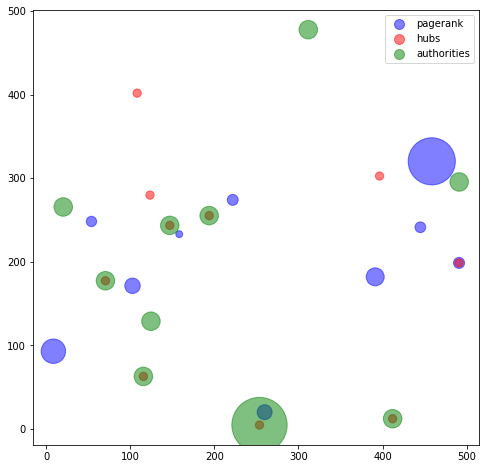

In [ ]:
# Compute 500 random points in [0,500]x[0,500]
N = 500
x = 500*np.random.rand(N)
#x = np.arange(500)
y = 500*np.random.rand(N)

# Rescale value of pagerank, hubs, authorities for 10 top nodes
area_pg = (500 * centralities["pagerank"][table['pagerank']])**2  
area_aut = (500 * centralities["authorities"][table['authorities']])**2  
area_hubs = (500 * centralities["hubs"][table['hubs']])**2  

plt.figure(figsize=(8, 8))
plt.scatter(x[table['pagerank']], y[table['pagerank']], s=area_pg, color='blue', alpha=0.5, label = 'pagerank')
plt.scatter(x[table['hubs']], y[table['hubs']], s=area_aut, color='red', alpha=0.5, label = 'hubs')
plt.scatter(x[table['authorities']], y[table['authorities']], s=area_hubs, color='green', alpha=0.5, label = 'authorities')
#plt.xlim(-50, 550)
#plt.ylim(-50, 550)
# legend with same size
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([100.0])

plt.show()

I do also graphs in which I plot in $x-axis$ pagerank and in $y-axis$ hubs and authorities. \\
To see a high correlation we should have points near the bisector. 

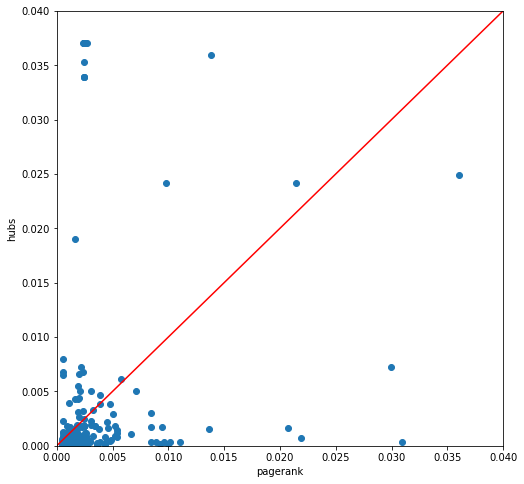

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(centralities['pagerank'], centralities['hubs'])
plt.xlim(0, 0.04)
plt.ylim(0, 0.04)
plt.plot([0, 0.1], [0,0.1], 'k-', color = 'r')
plt.xlabel('pagerank')
plt.ylabel('hubs')
plt.show()

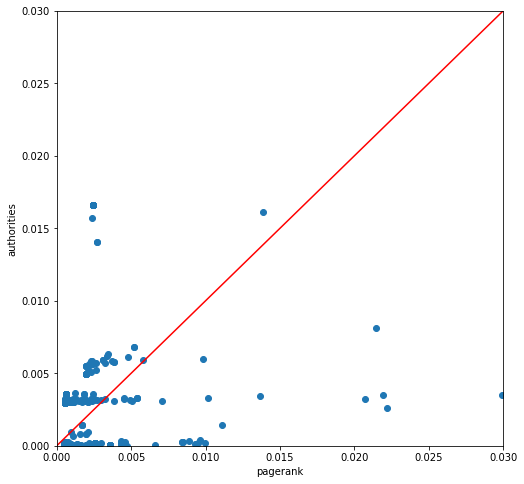

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(centralities['pagerank'], centralities['authorities'])
plt.xlim(0, 0.03)
plt.ylim(0, 0.03)
plt.plot([0, 0.1], [0,0.1], 'k-', color = 'r')
plt.xlabel('pagerank')
plt.ylabel('authorities')
plt.show()

## Let's work with a hypergraph 
We consider now a hypergraph dataset made out of Mathoverflow Q&As. Each node is tag given to a post by users of the popular platform and these tags are connected by an hyperedge (also called "simplex" by the data provider) if they appear together as descriptors of some posts. Hyperedges have a timestamp which you should ignore.

In [ ]:
def read_int_lines(dataset):
    # function that reads dataset of integers (one for line) and return the list of them

    f = open(dataset) 
    lista = []
    for row in f.readlines():
      lista.append(int(row))
    f.close() 
    #lista = np.array(lista) # molto più veloce senza np.array
    return lista

In [ ]:
def read_tags_data_node_labels(dataset):
    # function that reads dataset of labels (in this case take only string ignoring numbers)
    
    labels = []
    f = open(dataset)
    for row in f.readlines():
            data = (row.strip()).split()
            labels.append(data[1])
    f.close() 
    return labels

Load labels, simpleces and number of vertices in each simpleces

In [ ]:
labels = read_tags_data_node_labels('tags-math-sx-node-labels.txt')
simpleces = read_int_lines('tags-math-sx-simplices.txt')
nverts = read_int_lines('tags-math-sx-nverts.txt')

Construct list with all simpleces

In [ ]:
curr_ind = 0   # current index
tot_edge = []  # list in which each element is list of nodes in a simplex 

for nvert in nverts: 
        edge = simpleces[curr_ind:(curr_ind + nvert)] 
        curr_ind += nvert
        tot_edge.append(edge)

### Q3. 
Compute the eigenvector centrality and the Pagerank ($\alpha = 0.85$, uniform probability to random jump) centrality of the clique-expanded graph of this hypergraph. Print a table with the names of the top TEN nodes for both the two centralities and do a scatter plot comparing them (recall you should normalize the centrality vectors so that they sum up to one)

In [ ]:
def adjacency_mat_from_simpleces(tot_edge,n):
  # Input: list with list of edges in simplex, dimension of A
  # Output: adjacency matrix

  A = np.zeros([n+1,n+1])     # index in tot_edge go from 1 to n
  for hedge in tot_edge:      # take a hyperedge
    k = hedge.copy()        # copy the hyperedge
    for node in hedge:         # take a node
      k.remove(node)          
      for node_2 in k:
        A[node,node_2]+=1
        
  return sp.sparse.csr_matrix(A[1:,1:])

In [ ]:
n = len(labels) # matrix dimension
A = adjacency_mat_from_simpleces(tot_edge,n)

Take the largest strongly connected component

In [ ]:
A,labels = largest_strongly_connected_component(A,labels) 
n = len(labels) # matrix dimension

### Table

In [ ]:
centralities = dict();
random_jump_vector=(1/n)*np.ones(n)                      # needeed for pagerank
for name in names:
    centralities[name] = compute_centrality(A,name=name)

In [ ]:
# Create dict with name centralities and nodes (if you want to see node names is sufficient to eliminate comment)
table = dict()
for name in names:
  top_nodes_name, top_nodes_index = top_nodes_table(centralities[name],labels)
  table[name] = top_nodes_index
  #table[name] = top_nodes_name

df = pd.DataFrame(table)
  
# displaying the DataFrame
pd.DataFrame(df)

,d_in,d_out,pagerank,hubs,authorities,eig_in,eig_out
0,55,4,636,4,55,4,455
1,5,52,968,52,5,52,91
2,64,15,1015,55,71,15,11
3,24,38,615,15,52,132,389
4,136,132,1003,71,64,55,136
5,91,55,380,132,136,71,333
6,455,71,552,64,258,38,69
7,71,218,963,95,333,128,507
8,69,16,993,128,225,64,265
9,333,128,805,218,91,95,288


### Scatter

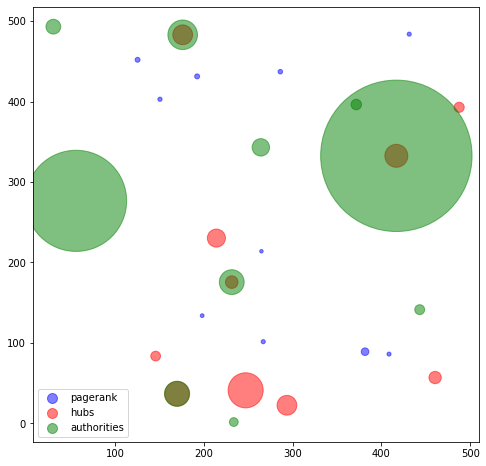

In [ ]:
# Compute 500 random points in [0,500]x[0,500]
N = n
x = 500*np.random.rand(N)
y = 500*np.random.rand(N)

# Rescale value of pagerank, hubs, authorities for 10 top nodes
area_pg = (500 * centralities["pagerank"][table['pagerank']])**2  
area_aut = (500 * centralities["authorities"][table['authorities']])**2  
area_hubs = (500 * centralities["hubs"][table['hubs']])**2  

plt.figure(figsize=(8, 8))
plt.scatter(x[table['pagerank']], y[table['pagerank']], s=area_pg, color='blue', alpha=0.5, label = 'pagerank')
plt.scatter(x[table['hubs']], y[table['hubs']], s=area_aut, color='red', alpha=0.5, label = 'hubs')
plt.scatter(x[table['authorities']], y[table['authorities']], s=area_hubs, color='green', alpha=0.5, label = 'authorities')
#plt.xlim(-50, 550)
#plt.ylim(-50, 550)
# legend with same size
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([100.0])

plt.show()

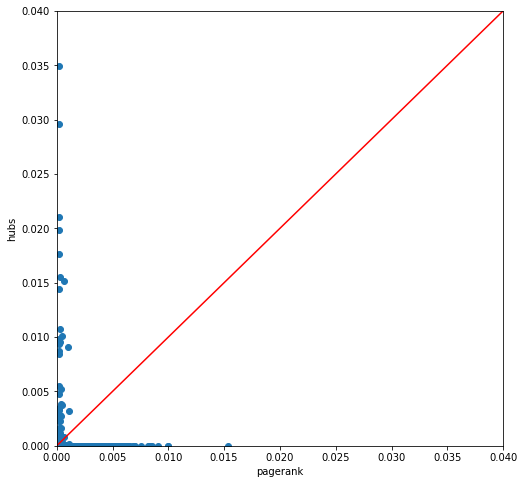

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(centralities['pagerank'], centralities['hubs'])
plt.xlim(0, 0.04)
plt.ylim(0, 0.04)
plt.plot([0, 0.1], [0,0.1], 'k-', color = 'r')
plt.xlabel('pagerank')
plt.ylabel('hubs')
plt.show()

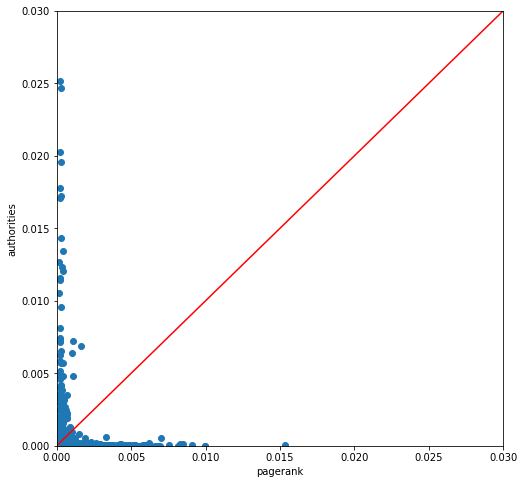

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(centralities['pagerank'], centralities['authorities'])
plt.xlim(0, 0.03)
plt.ylim(0, 0.03)
plt.plot([0, 0.1], [0,0.1], 'k-', color = 'r')
plt.xlabel('pagerank')
plt.ylabel('authorities')
plt.show()

# Semi supervised learning 

Now we use Pagerank to predict the class (or label) of a partially labeled network dataset. This is a co-citation dataset made by journal papers which are connected if they cite each other. We have two datasets:
1. cora-cit-graph: citation graph where each edge is a citation from paper x to paper y 
2. cora-cit-hypergraph: citation hypergraph where each hyperedge contains the list of papers cited by some paper
Both datasets are saved in python's `pickle` format which should be easy to read also from Matlab and Julia

## Label spreading cora-cit-graph
Here you should implement label spreading, a.k.a. PageRank on these datasets. 
1. For each of the labels, randomly select 5% of the nodes with that label to be your class-balanced training data. 
2. On the graph dataste, implement label spreading for 3 values of $\alpha = 0.25$, $0.5$, and $0.75$ using only labels as input embedding. 
3. Compute the accuracy, precision and recall on the test set (the unlabeled nodes). 
4. Repeat the same experiment with 10% of the nodes per label. 
5. Plot the accuracy, precision and recall as a function of alpha for the two experiments. 
6. Repeat these experiments by using label-spreading on the clique expanded graph of the hypegraph dataset. Pay attention, the indices of the nodes in the datasets are different, so make sure you reload the feature data for the hypergraph. 


In [ ]:
 graph = pd.read_pickle('graph.p')          # dictionary with key=node and values=nodes connected
 features = pd.read_pickle('features.p')    # matrix
 labels = pd.read_pickle('labels.p')        # np.array (2708,7)

### Function preamble

In [ ]:
def adjacency_from_graph(graph):
  # Compute adjacency matrix from dict graph 
  
  n = len(graph)
  A = np.zeros([n,n])           
  for i in range(n):
    A[graph[i],i]=1
    A[i,graph[i]]=1
  return sp.sparse.csr_matrix(A)

In [ ]:
def tensor_pagerank(A, Y, alfa):
  # Compute pagerank

  n = np.shape(A)[0]                                    # A dimension
  d_out = A@(np.ones(n))                                # D = A 1
  invD = sp.sparse.diags(1/d_out)                       # D^-1
  M = sp.sparse.diags(np.ones(n))-alfa*A.T@invD         # M = [1 - (alfa * A^t * D^-1)]   
  X = sp.sparse.linalg.spsolve(sp.sparse.csc_matrix(M),(1-alfa)*Y)
  return X

In [ ]:
def Y_matrix(vec_labels, labels, perc):
  # Input:  vector with labels, matrix of labels, percentage of node in training data
  # Output: training_data, Y matrix

  training_data = np.array([],dtype=int)                          # initialize training data
  dim_labels = np.shape(labels)                                   # shape of matrix labels
  Y = np.zeros(dim_labels)                                        # initialize matrix Y
  
  for i in range(dim_labels[1]):                               
    index = np.where(vec_labels==i)[0]                            # find all nodes with the same labels
    position = np.random.choice(index, perc[i], replace=False)    # take random elements
    training_data = np.concatenate((training_data,position))      # append position of training data

  Y[training_data,:] = labels[training_data,:]                    # define Y 

  return training_data, Y/perc

In [ ]:
def validation_metrics(confusion_matrix):
  # Input: confusion matrix
  # Output: compute accuracy, precision, recall
  
  accuracy=sum(np.diag(confusion_matrix))/np.sum(confusion_matrix)

  precision = []
  for i in range(len(confusion_matrix)):
    precision.append(confusion_matrix[i,i]/(sum(confusion_matrix[:,i])))

  recall = []
  for i in range(len(confusion_matrix)):
    recall.append(confusion_matrix[i,i]/(sum(confusion_matrix[i,:])))
  
  return accuracy, np.mean(precision), np.mean(recall)

I modify the function that returns the largest strongly connected component in order to give back also the new set of labels.

In [ ]:
def largest_strongly_connected_component_labels(Adj, tot_link):
  # Input: adjacency matrix, list of node names
  # Output: adj matrix of the largest strongly connected component, updated list of node names

  # adj matrix of the largest strongly connected component
  G = nx.from_numpy_matrix(Adj.toarray(),create_using=nx.DiGraph)  # graph 
  index = max(nx.strongly_connected_components(G), key=len)        # set of nodes in largest scc    
  index= list(index)                                               # tranform in list
  A = Adj[index,:][:,index]                                        # extract adj matrix of largest scc    

  # extract list of node names                       
  link = tot_link[index,:]                             
  
  return A, link

### Labels 5%

Construct adjacency matrix, for each of the labels randomly select 5% of  the nodes that are needed to construct Y matrix. \\
Then implement label spreading for 3 values of $\alpha$.

In [ ]:
A = adjacency_from_graph(graph)  # sparse adjacency matrix

Take the largest strongly connected component

In [ ]:
A, labels = largest_strongly_connected_component_labels(A, labels)

In [ ]:
tot_labels = np.sum(labels, axis=0)   # total number of data for each class
five_perc = tot_labels//20            # number of training data for each class
vec_labels = np.argmax(labels,axis=1) # vector of labels (before we have matrix, now only index)

In [ ]:
index_training_data, Y = Y_matrix(vec_labels, labels, five_perc)  # position of training data and matrix Y 

Compute confusion matrix in the case in which $\alpha = 0.75$ and calculate accuracy, precision and recall.

In [ ]:
alfa = 0.75
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(vec_labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc5_1,prec5_1,rec5_1 = validation_metrics(cm)
print('Accuracy:', acc5_1, '\nRecall:', rec5_1, '\nPrecision:', prec5_1)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7148900169204738 
Recall: 0.7391674105822552 
Precision: 0.686392451506396


,0,1,2,3,4,5,6
0,188,29,4,27,21,19,39
1,3,171,12,5,5,7,1
2,0,21,346,11,1,2,5
3,43,73,28,439,36,26,45
4,29,7,1,46,255,21,2
5,21,15,6,1,13,187,28
6,11,1,0,0,6,3,104


Compute confusion matrix in the case in which $\alpha = 0.5$ and calculate accuracy, precision and recall.

In [ ]:
alfa = 0.5
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(vec_labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc5_2,prec5_2,rec5_2 = validation_metrics(cm)
print('Accuracy:', acc5_2, '\nRecall:', rec5_2, '\nPrecision:', prec5_2)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7021996615905245 
Recall: 0.7214938866665859 
Precision: 0.672778186223453


,0,1,2,3,4,5,6
0,186,29,4,30,22,20,36
1,3,165,15,7,4,9,1
2,0,25,345,8,1,2,5
3,48,82,23,433,34,31,39
4,30,9,1,45,255,20,1
5,26,16,6,1,20,177,25
6,14,1,0,0,7,4,99


Compute confusion matrix in the case in which $\alpha = 0.25$ and calculate accuracy, precision and recall.

In [ ]:
alfa = 0.25
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(vec_labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc5_3,prec5_3,rec5_3 = validation_metrics(cm)
print('Accuracy:', acc5_3, '\nRecall:', rec5_3, '\nPrecision:', prec5_3)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.6950084602368867 
Recall: 0.7148326223573147 
Precision: 0.6669637802057503


,0,1,2,3,4,5,6
0,184,28,6,31,24,19,35
1,4,163,15,7,2,12,1
2,0,28,342,8,1,1,6
3,47,89,21,428,35,33,37
4,32,9,1,46,252,20,1
5,28,18,6,1,20,175,23
6,14,1,0,0,7,4,99


### Labels 10%

In [ ]:
tot_labels = np.sum(labels, axis=0)   # total number of data for each class
ten_perc = tot_labels//10             # number of training data for each class
vec_labels = np.argmax(labels,axis=1) # vector of labels

In [ ]:
index_training_data, Y = Y_matrix(vec_labels, labels, ten_perc)   # position of training data and matrix Y 

Compute confusion matrix in the case in which $\alpha = 0.75$ and calculate accuracy, precision and recall.



In [ ]:
X = tensor_pagerank(A, Y, alfa=0.75)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(vec_labels, maxX)
cm = cm-np.diag(ten_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc10_1,prec10_1,rec10_1 = validation_metrics(cm)
print('Accuracy:', acc10_1, '\nRecall:', rec10_1, '\nPrecision:', prec10_1)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7714285714285715 
Recall: 0.782406347260318 
Precision: 0.7443277630513518


,0,1,2,3,4,5,6
0,209,8,3,24,8,15,43
1,3,155,18,11,0,4,2
2,4,3,341,3,1,10,4
3,59,27,19,483,32,13,21
4,28,18,0,32,257,2,5
5,23,9,6,10,2,179,28
6,6,1,1,1,0,5,104


Compute confusion matrix in the case in which $\alpha = 0.5$ and calculate accuracy, precision and recall.

In [ ]:
X = tensor_pagerank(A, Y, alfa=0.5)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(vec_labels, maxX)
cm = cm-np.diag(ten_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc10_2,prec10_2,rec10_2 = validation_metrics(cm)
print('Accuracy:', acc10_2, '\nRecall:', rec10_2, '\nPrecision:', prec10_2)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7607142857142857 
Recall: 0.7682528869422691 
Precision: 0.7356938035240069


,0,1,2,3,4,5,6
0,207,7,5,29,9,14,39
1,5,151,18,13,0,4,2
2,4,3,341,3,1,10,4
3,60,25,19,484,35,13,18
4,27,14,1,45,247,2,6
5,22,12,7,11,4,172,29
6,5,1,1,2,0,7,102


Compute confusion matrix in the case in which $\alpha = 0.25$ and calculate accuracy, precision and recall.

In [ ]:
X = tensor_pagerank(A, Y, alfa=0.25)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(vec_labels, maxX)
cm = cm-np.diag(ten_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc10_3,prec10_3,rec10_3 = validation_metrics(cm)
print('Accuracy:', acc10_3, '\nRecall:', rec10_3, '\nPrecision:', prec10_3)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7558035714285715 
Recall: 0.7596525049142434 
Precision: 0.733465858224032


,0,1,2,3,4,5,6
0,205,8,6,33,9,14,35
1,5,145,19,18,0,4,2
2,4,3,341,3,1,13,1
3,60,23,19,486,36,13,17
4,27,10,1,51,244,2,7
5,20,12,7,18,4,172,24
6,6,1,1,2,0,8,100


### Accuracy, precision and recall as a function of alpha

In [ ]:
alpha=[0.75,0.5,0.25]

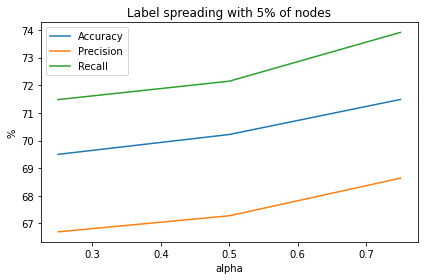

In [ ]:
plt.plot(alpha,[100*acc5_1,100*acc5_2,100*acc5_3])
plt.plot(alpha,[100*prec5_1,100*prec5_2,100*prec5_3])
plt.plot(alpha,[100*rec5_1,100*rec5_2,100*rec5_3])
plt.xlabel('alpha')
plt.ylabel('%')
plt.legend(['Accuracy','Precision','Recall'])
plt.title('Label spreading with 5% of nodes')
plt.tight_layout()
plt.show()

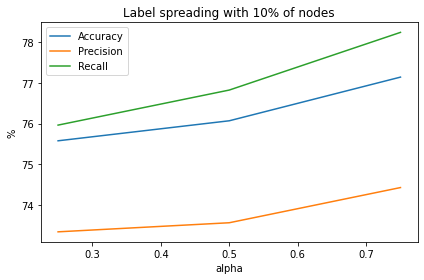

In [ ]:
plt.plot(alpha,[100*acc10_1,100*acc10_2,100*acc10_3])
plt.plot(alpha,[100*prec10_1,100*prec10_2,100*prec10_3])
plt.plot(alpha,[100*rec10_1,100*rec10_2,100*rec10_3])
plt.xlabel('alpha')
plt.ylabel('%')
plt.legend(['Accuracy','Precision','Recall'])
plt.title('Label spreading with 10% of nodes')
plt.tight_layout()
plt.show()

It is easy to see that as $\alpha$ increase so do accuracy, precision and recall. This can follow from the fact that with a bigger $\alpha$ the probability of random jump decreases. Nevertheless is not trivial that continuing to increase $\alpha$ then accuracy grows, $\alpha$ is an important variable that needs a fine tuning.

## Label spreading cora-cit-hypergraph

In [ ]:
hypergraph = pd.read_pickle('hypergraph.pickle')   # dictionary with values=nodes in simpleces
features = pd.read_pickle('features.pickle')
labels = pd.read_pickle('labels.pickle')           # vector (2708,)

Create incident matrix

In [ ]:
def incident_matrix(hypergraph,n):
  # Input: hypergraph, nodes number
  # Output: incident matrix
   
  m = len(hypergraph)            # number of hyperdge
  M = np.zeros([n,m])            # initialize M

  # create M
  for (j,i) in enumerate(hypergraph.keys()):
    M[list(hypergraph[i]),j]=1   

  return csr_matrix(M)

In [ ]:
n = len(labels)                         # number of nodes
M1 = incident_matrix(hypergraph, n)     # incident matrix

In [ ]:
A=M1@M1.T

In [ ]:
A=csr_matrix.toarray(A)

In [ ]:
np.diag(A)[1:100]

array([ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
       15.,  9.,  0.,  0.,  3.,  1.,  1.,  0.,  2.,  0.,  0.,  5.,  0.,
        0.,  0.,  0.,  5.,  0.,  1.,  1.,  0.,  1.,  5.,  1.,  2.,  2.,
        0., 10.,  1.,  1.,  0.,  1.,  2.,  0.,  3.,  0.,  0.,  0.,  2.,
        0.,  0.,  3.,  0.,  1.,  4.,  4.,  2.,  0.,  4.,  3.,  1.,  0.,
       13.,  0.,  6.,  0.,  6.,  6.,  2.,  0., 33.,  5., 13.,  1.,  2.,
        0.,  0.,  0.,  7.,  0.,  7.,  2.,  3.,  2.,  7.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.])

Create adjacency matrix from incident matrix and take largest strongly connected component.

In [ ]:
A, labels = largest_strongly_connected_component(M1@M1.T, labels)
_, features = largest_strongly_connected_component_labels(M1@M1.T, features)
n = len(labels)                         # number of nodes

In [ ]:
for i in range(np.shape(A)[0]):
  A[i,i]=0

Count number of data in each class

In [ ]:
tot_labels = []                       # numbers of data for each class
num_labels = max(labels)+1            # numbers of labels
for i in range(num_labels):
  tot_labels.append(labels.count(i))

# transform in np.array
tot_labels = np.array(tot_labels)
labels = np.array(labels)

Create matrix of labels

In [ ]:
mat_labels = np.zeros([n,num_labels])
for el in enumerate(labels):
   mat_labels[el]=1

### Label 5%

Find solution and plot the result

In [ ]:
five_perc = tot_labels//20            # number of training data for each class

In [ ]:
index_training_data, Y = Y_matrix(labels, mat_labels, five_perc)  # position of training data and matrix Y 

Compute confusion matrix in the case in which $\alpha = 0.75$ and calculate accuracy, precision and recall.

In [ ]:
alfa=0.75
X = tensor_pagerank(A, Y, alfa)   # matrix
maxX = np.argmax(X, axis=1)       # solution is index of maximum for each row

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc5_1,prec5_1,rec5_1 = validation_metrics(cm)
print('Accuracy:', acc5_1, '\nRecall:', rec5_1, '\nPrecision:', prec5_1)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7053712480252765 
Recall: 0.7130036658565722 
Precision: 0.6822196367894879


,0,1,2,3,4,5,6
0,193,5,1,7,1,0,3
1,2,123,19,14,9,9,10
2,1,10,44,1,5,0,1
3,21,38,21,200,5,15,34
4,6,25,12,2,94,2,4
5,2,21,1,21,8,153,5
6,14,3,3,2,3,7,86


Compute confusion matrix in the case in which $\alpha = 0.5$ and calculate accuracy, precision and recall.

In [ ]:
alfa = 0.5
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc5_2,prec5_2,rec5_2 = validation_metrics(cm)
print('Accuracy:', acc5_2, '\nRecall:', rec5_2, '\nPrecision:', prec5_2)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.6895734597156398 
Recall: 0.6894528587294563 
Precision: 0.6683392422371618


,0,1,2,3,4,5,6
0,192,7,1,8,0,0,2
1,8,123,16,13,8,10,8
2,2,14,39,2,5,0,0
3,21,44,22,194,5,13,35
4,6,25,10,7,90,1,6
5,3,20,0,22,8,153,5
6,15,4,3,2,4,8,82


Compute confusion matrix in the case in which $\alpha = 0.25$ and calculate accuracy, precision and recall.

In [ ]:
alfa = 0.25
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc5_3,prec5_3,rec5_3 = validation_metrics(cm)
print('Accuracy:', acc5_3, '\nRecall:', rec5_3, '\nPrecision:', prec5_3)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.6800947867298578 
Recall: 0.6783452897354868 
Precision: 0.6581110736088973


,0,1,2,3,4,5,6
0,188,7,1,10,0,0,4
1,8,121,16,15,8,10,8
2,2,15,38,2,5,0,0
3,17,43,22,191,6,14,41
4,6,24,10,9,89,1,6
5,3,20,0,21,8,155,4
6,15,8,3,1,4,8,79


### Label 10%

In [ ]:
ten_perc = tot_labels//10            # number of training data for each class

In [ ]:
index_training_data, Y = Y_matrix(labels, mat_labels, ten_perc)  # position of training data and matrix Y 

Compute confusion matrix in the case in which $\alpha = 0.75$ and calculate accuracy, precision and recall.

In [ ]:
alfa=0.75
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc10_1,prec10_1,rec10_1 = validation_metrics(cm)
print('Accuracy:', acc10_1, '\nRecall:', rec10_1, '\nPrecision:', prec10_1)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7472353870458136 
Recall: 0.7656971834356207 
Precision: 0.719256129440238


,0,1,2,3,4,5,6
0,190,2,1,11,2,0,4
1,2,117,24,7,16,9,11
2,0,4,55,0,0,1,2
3,8,33,16,228,12,9,28
4,4,2,16,4,108,1,10
5,1,15,4,20,4,158,9
6,14,2,2,3,3,4,90


Compute confusion matrix in the case in which $\alpha = 0.5$ and calculate accuracy, precision and recall.

In [ ]:
alfa=0.5
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc10_2,prec10_2,rec10_2 = validation_metrics(cm)
print('Accuracy:', acc10_2, '\nRecall:', rec10_2, '\nPrecision:', prec10_2)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7401263823064771 
Recall: 0.7507711528227249 
Precision: 0.7117365773970494


,0,1,2,3,4,5,6
0,190,2,1,11,1,0,5
1,2,119,17,7,17,13,11
2,0,8,49,0,1,2,2
3,7,31,10,225,16,10,35
4,4,4,14,4,108,1,10
5,1,17,2,21,3,156,11
6,14,3,1,3,3,4,90


Compute confusion matrix in the case in which $\alpha = 0.25$ and calculate accuracy, precision and recall.

In [ ]:
alfa=0.25
X = tensor_pagerank(A, Y, alfa)
maxX = np.argmax(X, axis=1)

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, maxX)
cm = cm-np.diag(five_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc10_3,prec10_3,rec10_3 = validation_metrics(cm)
print('Accuracy:', acc10_3, '\nRecall:', rec10_3, '\nPrecision:', prec10_3)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7211690363349131 
Recall: 0.72787782489164 
Precision: 0.6917804965300907


,0,1,2,3,4,5,6
0,189,3,1,8,0,0,9
1,2,117,19,7,17,14,10
2,0,13,44,0,1,2,2
3,18,26,7,213,18,13,39
4,6,4,13,4,102,5,11
5,1,17,1,20,6,157,9
6,14,3,1,2,3,4,91


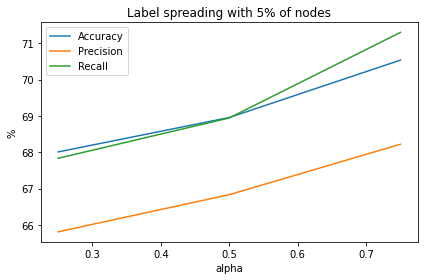

In [ ]:
plt.plot(alpha,[100*acc5_1,100*acc5_2,100*acc5_3])
plt.plot(alpha,[100*prec5_1,100*prec5_2,100*prec5_3])
plt.plot(alpha,[100*rec5_1,100*rec5_2,100*rec5_3])
plt.xlabel('alpha')
plt.ylabel('%')
plt.legend(['Accuracy','Precision','Recall'])
plt.title('Label spreading with 5% of nodes')
plt.tight_layout()
plt.show()

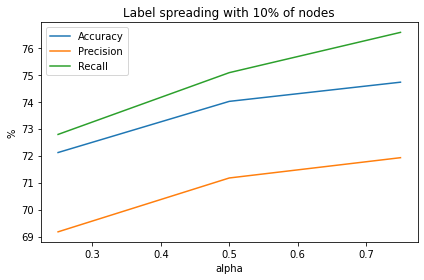

In [ ]:
plt.plot(alpha,[100*acc10_1,100*acc10_2,100*acc10_3])
plt.plot(alpha,[100*prec10_1,100*prec10_2,100*prec10_3])
plt.plot(alpha,[100*rec10_1,100*rec10_2,100*rec10_3])
plt.xlabel('alpha')
plt.ylabel('%')
plt.legend(['Accuracy','Precision','Recall'])
plt.title('Label spreading with 10% of nodes')
plt.tight_layout()
plt.show()

### Feature spreading (optional)
Now we want observe improvements, if any, obtained when using all the node features as input embedding. Recall $Y\sim n\times K$ is the one-hot encoding of the input labels, i.e. a matrix with $K$ columns each of which has exactly one nonzero entry pointing at the label number of that node; $X\sim n\times d$ is a matrix of features, where each row is the feature vector of the corresponding node. 

First we do a sanity check:
1. train a logistic regression classifier using $Y$ and use it to predic the labels on the test data (the nonlabeled nodes) after label spreading instead of using argmax on the rows. Verify that you get the same (or almost the same) accuracy.
You can do this by using python's `sklearn` see eg [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
logis = LogisticRegression()     # Initialize logistic regression

Compute training data and their labels. $x-train$ are just rows of $Y$ for which I know the label where I substitude to the non-zero entry a very high value. I do that in order to have a logistic regression that works as an $argmax$.


In [ ]:
x_train = Y[index_training_data,:]
y_train = labels[index_training_data]
x_train[np.where(x_train>0)]=10000000

Train the logistic regression and use it to predict labels on test data

In [ ]:
logis.fit(x_train,y_train)
sol = logis.predict(X)

As one can see behind we get almost the same accuracy as before.

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, sol)
cm = cm-np.diag(ten_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc,prec,rec = validation_metrics(cm)
print('Accuracy:', acc, '\nRecall:', rec, '\nPrecision:', prec)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7422852376980817 
Recall: 0.722324202790328 
Precision: 0.7301432792462543


,0,1,2,3,4,5,6
0,179,3,0,16,0,0,1
1,3,110,7,16,16,17,7
2,1,12,36,4,1,2,3
3,9,26,3,241,12,12,13
4,7,7,3,5,96,6,13
5,1,15,1,28,2,147,6
6,17,3,0,4,3,4,81


Second, we run label spreading using the whole features as input. In other words we look at the limit point $Z^*$ of the sequence 
$$
    Z^{(r+1)} = \alpha AD^{-1}Z^{(r)} + (1-\alpha)[Y X]
$$
where $[YX] \sim n \times (K+d)$ is the matrix obtained stacking label one-hot encoding and feature vectors one after the other. 


We repeat the same experiments as in the points 1-6 above, but predictions are now done using logistic regression on the new embedding:
 - Once the $n\times (K\times d)$ matrix $Z^*$ is computed we train a logistic regression classifier using the new embedding given by the rows of $Z^*$ corresponding to the training nodes (the nodes we know the label of) and then fitting it to predict the label of the unlabeled points. 

**Warning:**  
running LS on the whole feature embedding (with size $K+d$) may be expensive. To avoid long waits, I suggest you first subsample and choose for example only the first say 50 columns of $X$

Take 10% of data from each class and use them as training data

In [ ]:
ten_perc = tot_labels//10            # number of training data for each class
index_training_data, Y = Y_matrix(labels, mat_labels, ten_perc)

In [ ]:
H = sp.sparse.hstack([csr_matrix(Y),features],format='csc') # concatenate Y and features

Find solution of the new system with $\alpha=0.75$

In [ ]:
alfa=0.75
Z = sp.sparse.csc_matrix.toarray(tensor_pagerank(sp.sparse.csc_matrix(A), H, alfa))

Implement a logistic regression

In [ ]:
logis = LogisticRegression()            # Initialization
x_train = Z[index_training_data,:]
y_train = labels[index_training_data]
logis.fit(x_train,y_train)              # train
sol = logis.predict(Z)                  # solution

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, sol)
cm = cm-np.diag(ten_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc1,prec1,rec1 = validation_metrics(cm)
print('Accuracy:', acc1, '\nRecall:', rec1, '\nPrecision:', prec1)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7706422018348624 
Recall: 0.6717698572016831 
Precision: 0.8394818356800566


,0,1,2,3,4,5,6
0,188,2,0,6,1,0,2
1,3,129,0,27,2,14,1
2,1,31,9,13,4,1,0
3,7,7,0,292,1,8,1
4,3,18,0,20,93,3,0
5,1,4,0,31,3,161,0
6,13,6,0,37,0,4,52


Find solution of the new system with $\alpha=0.5$

In [ ]:
alfa=0.5
Z = sp.sparse.csc_matrix.toarray(tensor_pagerank(sp.sparse.csc_matrix(A), H, alfa))

Implement a logistic regression

In [ ]:
logis = LogisticRegression()            # Initialization
x_train = Z[index_training_data,:]
y_train = labels[index_training_data]
logis.fit(x_train,y_train)              # train
sol = logis.predict(Z)                  # solution

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, sol)
cm = cm-np.diag(ten_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc2,prec2,rec2 = validation_metrics(cm)
print('Accuracy:', acc2, '\nRecall:', rec2, '\nPrecision:', prec2)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.7456213511259383 
Recall: 0.6561914925198894 
Precision: 0.7994003526791124


,0,1,2,3,4,5,6
0,184,3,0,7,1,1,3
1,9,117,0,30,2,17,1
2,2,20,11,18,5,3,0
3,9,8,0,283,0,15,1
4,3,16,1,20,90,5,2
5,5,9,0,29,4,153,0
6,13,10,0,28,0,5,56


Find solution of the new system with $\alpha=0.25$

In [ ]:
alfa=0.25
Z = sp.sparse.csc_matrix.toarray(tensor_pagerank(sp.sparse.csc_matrix(A), H, alfa))

Implement a logistic regression

In [ ]:
logis = LogisticRegression()            # Initialization
x_train = Z[index_training_data,:]
y_train = labels[index_training_data]
logis.fit(x_train,y_train)              # train
sol = logis.predict(Z)                  # solution

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(labels, sol)
cm = cm-np.diag(ten_perc)                       # remove data of which I know labels

# Compute the accuracy of the class assignment
acc3,prec3,rec3 = validation_metrics(cm)
print('Accuracy:', acc3, '\nRecall:', rec3, '\nPrecision:', prec3)

# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.6997497914929107 
Recall: 0.6112249801337878 
Precision: 0.765557586816999


,0,1,2,3,4,5,6
0,179,4,0,11,0,2,3
1,13,102,0,36,2,21,2
2,3,15,9,24,3,4,1
3,9,12,0,274,0,20,1
4,9,17,1,25,77,5,3
5,8,10,0,38,4,140,0
6,11,9,0,28,0,6,58


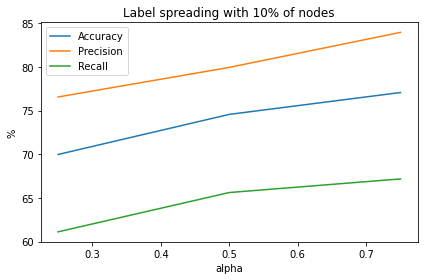

In [ ]:
plt.plot(alpha,[100*acc1,100*acc2,100*acc3])
plt.plot(alpha,[100*prec1,100*prec2,100*prec3])
plt.plot(alpha,[100*rec1,100*rec2,100*rec3])
plt.xlabel('alpha')
plt.ylabel('%')
plt.legend(['Accuracy','Precision','Recall'])
plt.title('Label spreading with 10% of nodes')
plt.tight_layout()
plt.show()